In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt

reload()
# !pip install matplotlib-venn

In [2]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    for work in state.related - state.find("s0").related:
        backward |= (set(strategy.ref[work]) & state.related)
        forward |= (set(strategy.rev_ref[work]) & state.related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [3]:
len ([x for _, x in load_work_map_all_years() if x.category == "snowball"])

4

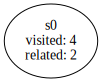

In [4]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
state


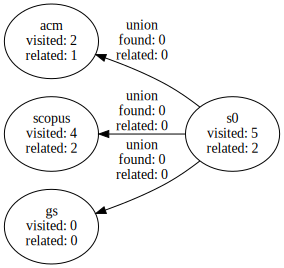

In [5]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["acm", "scopus", "gs"], filter_function)
#strategy.initial.find("acm")
strategy.initial

In [6]:
array = []

name = "E1"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E1
0.5
Recall E1
0.5


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

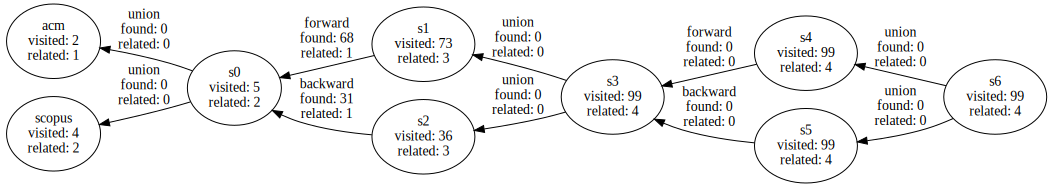

In [7]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

### Resumo 

#### Resumo da Busca em DL

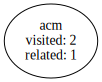

In [8]:
strategy.initial.find("acm")

In [9]:
# Visitados ACM
strategy.initial.find("acm").visited

{Cross-vs. within-company cost estimation studies revisited: an extended systematic review,
 Further comparison of cross-company and within-company effort estimation models for web applications}

In [10]:
# Relacionados ACM - encontrado no seed set
strategy.initial.find("acm").related

{Further comparison of cross-company and within-company effort estimation models for web applications}

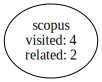

In [11]:
strategy.initial.find("scopus")

In [12]:
print("Visitados Scopus:")
strategy.initial.find("scopus").visited

Visitados Scopus:


{Web effort estimation: The value of cross-company data set compared to single-company data set,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 Using public domain metrics to estimate software development effort}

In [13]:
print("Relacionados Scopus - encontrado no seed set:")
strategy.initial.find("scopus").related

Relacionados Scopus - encontrado no seed set:


{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Further comparison of cross-company and within-company effort estimation models for web applications}

In [14]:
print("Artigo comum a ACM e Scopus:")
strategy.initial.find("acm").visited & strategy.initial.find("scopus").visited

Artigo comum a ACM e Scopus:


{Further comparison of cross-company and within-company effort estimation models for web applications}

#### Resumo do Snowballing

In [15]:
#Total de visitados = visitados no final - visitados no início
print ("Total visitados:")
len(state.visited - state.find("s0").visited)

Total visitados:


94

In [16]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
print ("Total Relacionados: Lista dos que foram encontrados via Snowballing")
state.related - state.find("s0").related

Total Relacionados: Lista dos que foram encontrados via Snowballing


{Building software cost estimation models using homogenous data,
 A comparison of cross-company and within-company effort estimation models for web applications}

In [17]:
print ("Encontrados via somente Snowballing:")
diff_related = state.related - state.find("s0").related
diff_related @ metakey_title

Encontrados via somente Snowballing:


['premraj2007a - Building software cost estimation models using homogenous data',
 'kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications']

### Detalhamento por Estado / Aresta

#### Estado S0

#### Visitados

In [18]:
#S0 - Visitados
print("Visitados no Estado 0:")
state.find("s0").visited

Visitados no Estado 0:


{Web effort estimation: The value of cross-company data set compared to single-company data set,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data,
 Using public domain metrics to estimate software development effort,
 Cross-vs. within-company cost estimation studies revisited: an extended systematic review,
 Further comparison of cross-company and within-company effort estimation models for web applications}

#### Relacionados - Seed Set

In [19]:
#S0 - Relacionados - Encontrados via busca e que existem na lista dos Incluídos da SLR existente - são os seed set!
print("Relacionados no Estado 0: Seed Set")
state.find("s0").related @ metakey_title

Relacionados no Estado 0: Seed Set


['ferrucci2012a - Web effort estimation: The value of cross-company data set compared to single-company data set',
 'mendes2004a - Further comparison of cross-company and within-company effort estimation models for web applications']

#### Aresta s0 -> s2 (Backward - Iteração 1)

In [20]:
# S2 - Backward (Found) - Visitados na iteração 1
print("Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_visited

Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:


{WWW2000: The Developer's view and a practitioner's approach to Web Engineering,
 Assessment and comparison of common software cost estimation modeling techniques,
 A comparison of cross-company and within-company effort estimation models for web applications,
 Individual comparisons by ranking methods,
 Statistical power analysis for the behavioral sciences,
 Local vs. global models for effort estimation and defect prediction,
 Case studies for method and tool evaluation,
 Cross-company vs. single-company web effort models using the Tukutuku database: An extended study,
 Investigating Web size metrics for early Web cost estimation,
 Using simulation to evaluate prediction techniques,
 Detection of influential observation in linear regression,
 Investigating early web size measures for web cost estimation,
 How to find relevant data for effort estimation?,
 Web cost estimation and productivity benchmarking,
 How valuable is company-specific data compared to multi-company data for softw

In [21]:
# S2 - Backward (Related) - Encontrados na iteração 1, via snowballing, que não foi encontrado via busca para o seed set.
print("Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_related @ metakey_title

Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:


['kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications']

#### Aresta s0 -> s1 (Forward - Iteração 1)

In [22]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['premraj2007a - Building software cost estimation models using homogenous data']

#### Relacionados - Encontrados Via Backward e Forward

In [23]:
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications'],
 ['premraj2007a - Building software cost estimation models using homogenous data']]

In [24]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
#v = venn2(sets, set_labels = ('Backward', 'Forward'))
#c = venn2_circles(sets)
#plt.title('Diagrama de Venn')
#plt.show()

In [25]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['mendes2004a']
Forward ['ferrucci2012a', 'mendes2004a']


In [26]:
#x = v.get_patch_by_id('100')

In [27]:
#x.set_linestyle = "black"

In [28]:
#[x.metakey for x in state.find("s0").related]

#### Execução de Backward (Aresta S0 -> S2) em cada artigo relacionado do S0

In [29]:
print("Descreve o S0 -> S2:\n Execução de Backward em cada artigo do related \n")
descreve_delta(strategy, state, "s2")

Descreve o S0 -> S2:
 Execução de Backward em cada artigo do related 

backward ferrucci2012a
- mendes2002a 
- kitchenham2007a 
- kitchenham2004a related
- conte1986a 
- kocaguneli2010a 
- cohen1988a 
- mendes2005a 
- li2009a 
- maxwell2002a 
- menzies2011a 
- kitchenham1995a 
- mendes2008b 
- kocaguneli2012a 
- mendes2007a 
- mendes2005b 
- shepperd2001a 
- cook1977a 
- kitchenham2001a 
- turhan2009a 
- mendes2003a 
- kocaguneli2011a 
- mendes2008a 
- kitchenham1998a 
backward mendes2004a
- kitchenham1998a 
- briand2000a 
- mendes2003a 
- wilcoxon1945a 
- christodoulou2000a 
- kitchenham1984a 
- briand1999a 
- shepperd2001a 
- mendes2003b 
- cook1977a 
- kemerer1987a 
- kitchenham2001a 
- kitchenham2004a related
- wieczorek2002a 
- maxwell2002a 
forward mendes2004a
- mendes2008b 
- mendes2007a 
- mendes2005b 
- kocaguneli2010a 
- kitchenham2007a 


#### Execução de Forward em cada artigo relacionado do S1

In [30]:
print("Descreve o S0 -> S1:\n Execução de Forward em cada artigo do related \n")
descreve_delta(strategy, state, "s1")

Descreve o S0 -> S1:
 Execução de Forward em cada artigo do related 

backward ferrucci2012a
- mendes2008b 
- mendes2007a 
- mendes2005b 
- kocaguneli2010a 
- kitchenham2007a 
forward ferrucci2012a
- corazza2015a 
- satapathy2017a 
- satapathy2016a 
- turhan2014a 
- huang2017a 
- dapozo2016a 
- lee2016a 
- huang2015a 
- finkelstein2013a 
- menzies2014a 
- minku2015a 
forward mendes2004a
- buglione2010a 
- baresi2007a 
- mendes2007b 
- wen2012a 
- premraj2007a related
- kitchenham2006a 
- shepperd2012a 
- lang2009a 
- premraj2005a 
- mittas2015a 
- martino2007a 
- mendes2009b 
- ferrucci2009a 
- kitchenham2007a 
- keung2008b 
- costagliola2006b 
- azhar2013a 
- mendes2007d 
- marco2012a 
- mair2005a 
- martino2016a 
- mittas2010b 
- abrahão2010a 
- marco2013a 
- martino2011a 
- matos2013a 
- kocaguneli2010a 
- baker2010a 
- minku2015a 
- zimmermann2009a 
- mendes2008e 
- mendes2008b 
- corazza2013a 
- corazza2011a 
- lokan2006a 
- mendes2005c 
- costagliola2006a 
- watanabe2008a 
- mend

#### Resumo do Precision e Recall

In [31]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision na Busca E2: 0.40%

Precision no Snowballing E2: 0.02%
Precision no Snowballing E2 - Forward - 1 iteração: 0.01%
Precision no Snowballing E2 - Backward - 1 iteração: 0.03%

Precision E2 (Busca + Snowballing): 0.04%
Precision E2
0.04040404040404041
Recall E2
1.0


## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

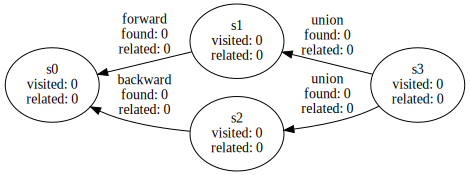

In [32]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [33]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E3


ZeroDivisionError: division by zero

## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

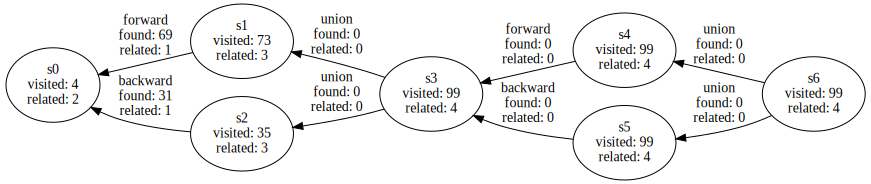

In [34]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.sfbu()
state

In [35]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E4
0.04040404040404041
Recall E4
1.0


In [36]:
state.find("s0").related

{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Further comparison of cross-company and within-company effort estimation models for web applications}

In [37]:
state.find("s2").related

{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 A comparison of cross-company and within-company effort estimation models for web applications}

In [38]:
state.find("s0").visited

{Web effort estimation: The value of cross-company data set compared to single-company data set,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 Using public domain metrics to estimate software development effort}

In [39]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

{A comparison of cross-company and within-company effort estimation models for web applications}

In [40]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

{A comparison of cross-company and within-company effort estimation models for web applications}

In [41]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

{Building software cost estimation models using homogenous data}

In [42]:
len(state.find("s1").delta_visited)

69

In [43]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

60

In [44]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

17

In [45]:
search_state = strategy.initial
search_state.related

{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Further comparison of cross-company and within-company effort estimation models for web applications}

## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

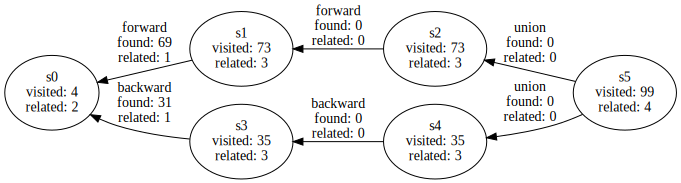

In [46]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [47]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E5
0.04040404040404041
Recall E5
1.0


In [48]:
state.find("s0").related 

{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Further comparison of cross-company and within-company effort estimation models for web applications}

In [49]:
state.find("s1").related 

{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data,
 Further comparison of cross-company and within-company effort estimation models for web applications}

In [50]:
state.find("s5").related 

{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 A comparison of cross-company and within-company effort estimation models for web applications}

In [51]:
sx, sy = state.previous[0]

sx.related & sy.related


{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Further comparison of cross-company and within-company effort estimation models for web applications}

In [52]:
sx.name

's2'

In [53]:
sy.name

's4'

## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

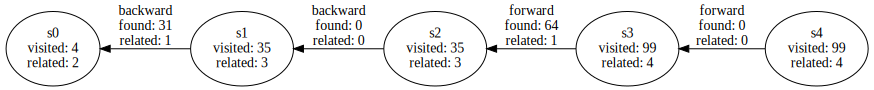

In [54]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [55]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E6
0.04040404040404041
Recall E6
1.0


## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

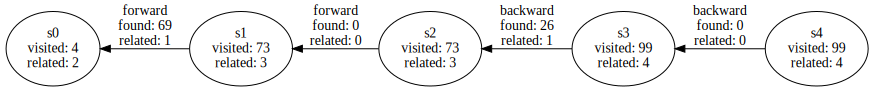

In [56]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [57]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E7
0.04040404040404041
Recall E7
1.0


# Análise das Estratégias

In [58]:
%matplotlib notebook
import pandas as pd

In [59]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall'])
df.index = df['Estratégia']
df

,Estratégia,Precision,Recall
Estratégia,,,
E1,E1,0.500000,0.5
E2,E2,0.040404,1.0
E4,E4,0.040404,1.0
E5,E5,0.040404,1.0
E6,E6,0.040404,1.0
E7,E7,0.040404,1.0


<IPython.core.display.Javascript object>


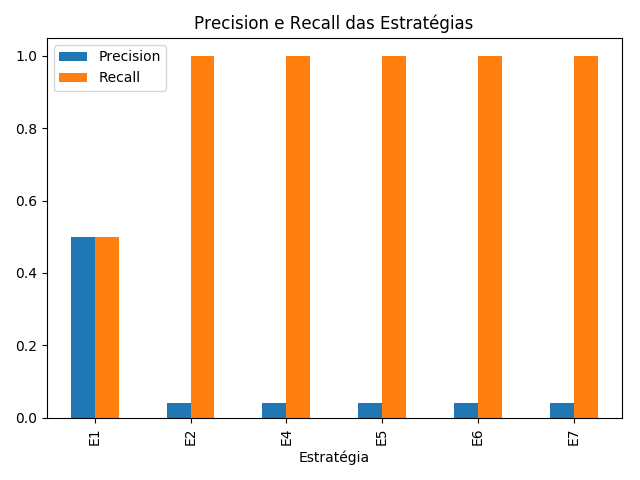

In [60]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()
